<a href="https://colab.research.google.com/github/stratoskar/thesis/blob/main/Python_Code/Notebook4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Phase 6: Making Future Predictions
In this final step of the research, we use the best model (XGBoost) to make predictions on unknown future data.

**Remember**: the data that were used had been recorded within the following time interval: [2008-05-18, 2008-05-24]. Now, we will forecast traffic flow on each path from 2008-05-25 and onwards.

In this step, the following commands are executed:

- Load traffic flow and weather data and preprocess them.
- Add time and statistically related features.
- Use the sliding window technique.
- Predict future traffic flow using XGBoost.



In [1]:
!pip install ipython-autotime

# measure execution time
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.1 MB/s eta 0:00:00
time: 347 µs (started: 2023-09-01 13:00:07 +00:00)


In [2]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

# library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# import Google Drive
from google.colab import drive

time: 519 ms (started: 2023-09-01 13:00:07 +00:00)


In [3]:
# access Google Drive, as we will read files from the cloud
drive.mount('/content/drive')

Mounted at /content/drive
time: 28.7 s (started: 2023-09-01 13:00:07 +00:00)


#### Step 1: Preprocess traffic flow data
We follow the same steps for data preprocessing as defined in Notebook3.ipynb file

In [4]:
# define the path with the time series SPQ data
traffic_data = '/content/drive/MyDrive/Colab Notebooks/San Francisco TF Pred/Preprocessing_Forecasting/Data/time_series_SPQ.txt'

# read dataset
time_series = pd.read_csv(traffic_data)

time: 4.1 s (started: 2023-09-01 13:00:36 +00:00)


In [5]:
# this list contains the column names
columns = ["Taxi ID","Traj ID","Path","Length"]

#### generate the columns of the dataset ####
i =4
while(True):
    if i == 4:
        columns.append(pd.to_datetime('2008-05-18 00:00:00'))
    else:
        columns.append(columns[i-1] + timedelta(seconds=1800))

    if (columns[i]>=pd.to_datetime('2008-05-24 23:59:59.000130')):
        break

    i+=1

# delete the last timestamp
columns.pop()

# assign new column names to our dataframe
time_series.columns = columns



#### generate new time columns for the dataset ####
dates = []
i = 0
while(True):
    if i == 0:
        dates.append(columns[-1] + timedelta(seconds=1800))
    else:
        dates.append(dates[i-1] + timedelta(seconds=1800))

    if (dates[i] == pd.to_datetime('2008-05-25 09:00:00')):
        break

    i+=1

#### add new columns to dataset ####
for value in dates:
    column_name = str(value)
    time_series[column_name] = -1

time: 46.1 ms (started: 2023-09-01 13:00:40 +00:00)


In [6]:
id_cols = ['Taxi ID','Traj ID', 'Path', 'Length']
time_cols = time_series.iloc[:,2:].columns

# reshape the data from wide format to long format using pandas melt function
time_series = time_series.melt(id_vars=id_cols, value_vars=time_cols, var_name='Time Column', value_name='Traffic Flow')

# change time column to datetime formaty
time_series['Time Column'] = pd.to_datetime(time_series['Time Column'])

# sort rows by Path and Time
time_series.sort_values(by=['Path','Time Column'],inplace=True)

time: 305 ms (started: 2023-09-01 13:00:40 +00:00)


In [7]:
# convert path column from categorical to numerical using Label Encoder library
from sklearn.preprocessing import LabelEncoder

# create an instance of LabelEncoder
label_encoder = LabelEncoder()

# fit label encoder on the 'Path' column
time_series['Path'] = label_encoder.fit_transform(time_series['Path'])

# sort the data based in Path column
time_series = time_series.sort_values(by=['Path','Time Column'])

# define new index for traffic flow data
time_series.set_index('Time Column', inplace=True)

time: 897 ms (started: 2023-09-01 13:00:40 +00:00)


In [8]:
# copy data to another dataframe
traffic_flow_data = time_series.copy()

time: 15.2 ms (started: 2023-09-01 13:00:41 +00:00)


In [9]:
# print data
time_series

,Taxi ID,Traj ID,Path,Length,Traffic Flow
Time Column,,,,,
2008-05-18 00:00:00,343,298,0,4,4
2008-05-18 00:30:00,343,298,0,4,4
2008-05-18 01:00:00,343,298,0,4,6
2008-05-18 01:30:00,343,298,0,4,3
2008-05-18 02:00:00,343,298,0,4,9
...,...,...,...,...,...
2008-05-25 07:00:00,248,615,999,11,-1
2008-05-25 07:30:00,248,615,999,11,-1
2008-05-25 08:00:00,248,615,999,11,-1


time: 14.5 ms (started: 2023-09-01 13:00:41 +00:00)


#### Step 2: Preprocess weather data
The weather dataset is the same as in Notebook3.ipynb.

In [10]:
# define path to weather data
weather_path = '/content/drive/MyDrive/Colab Notebooks/San Francisco TF Pred/Preprocessing_Forecasting/Data/weather_data.csv'

# read weather data
weather_data = pd.read_csv(weather_path,sep=',')

time: 789 ms (started: 2023-09-01 13:00:41 +00:00)


In [11]:
# drop unecessary columns
# dropped columns can either have NaN values, or not be associated with traffic flow.
# columns kept: temperature, humidity, windspeed, sealevelpressure, visibility
weather_data = weather_data.drop(['name','feelslike','dew','precip','precipprob','preciptype',
                                  'snow','snowdepth','windgust','winddir','cloudcover',
                                  'solarradiation','solarenergy','uvindex','severerisk','stations','icon'],axis=1)


time: 1.55 ms (started: 2023-09-01 13:00:42 +00:00)


In [12]:
# change the only 'Rain, Overcast' value to 'Overcast'
weather_data.loc[weather_data['conditions'] == 'Rain, Overcast', 'conditions'] = 'Overcast'

# one-hot encode the  "conditions" column
conditions = pd.get_dummies(weather_data['conditions'], prefix='conditions')
weather_data.drop('conditions',axis=1,inplace=True)

# concatenate the one-hot encoded columns to the original DataFrame
weather_data = pd.concat([weather_data, conditions], axis=1)

time: 83.6 ms (started: 2023-09-01 13:00:42 +00:00)


In [13]:
# convert datetime column to appropriate format
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])

# select specific time interval of weather_data
start_date = pd.to_datetime('2008-05-18')
end_date = pd.to_datetime('2008-05-26')
weather_data = weather_data[(weather_data['datetime'] >= start_date) & (weather_data['datetime'] <= end_date)].reset_index(drop=True)

# set time info as the index of the weather dataframe
weather_data.set_index('datetime', inplace=True)

time: 7.05 ms (started: 2023-09-01 13:00:42 +00:00)


#### Step 3: Connect two dataframes: weather data and traffic flow data

In [14]:
# resample the 'weather_data' dataset to 30-minute intervals and forward-fill the missing values
weather_data = weather_data.resample('30T').ffill()

# merge the time_series and weather_data_resampled datasets based on their indexes
time_series = time_series.merge(weather_data, left_index=True, right_index=True)

time: 87.7 ms (started: 2023-09-01 13:00:42 +00:00)


In [15]:
time_series = time_series.reset_index()
time_series.rename(columns={'index': 'Time Column'}, inplace=True)

time: 22.2 ms (started: 2023-09-01 13:00:42 +00:00)


In [16]:
# print dataframe
time_series

,Time Column,Taxi ID,Traj ID,Path,Length,Traffic Flow,temp,humidity,windspeed,sealevelpressure,visibility,conditions_Clear,conditions_Overcast,conditions_Partially cloudy
0,2008-05-18 00:00:00,343,298,0,4,4,12.4,87.29,16.1,1017.7,16.0,0,0,1
1,2008-05-18 00:00:00,370,177,1,4,2,12.4,87.29,16.1,1017.7,16.0,0,0,1
2,2008-05-18 00:00:00,440,355,2,2,5,12.4,87.29,16.1,1017.7,16.0,0,0,1
3,2008-05-18 00:00:00,459,48,3,9,4,12.4,87.29,16.1,1017.7,16.0,0,0,1
4,2008-05-18 00:00:00,219,392,4,12,0,12.4,87.29,16.1,1017.7,16.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354995,2008-05-25 09:00:00,127,127,995,3,-1,13.4,69.19,8.7,1014.5,16.0,0,0,1
354996,2008-05-25 09:00:00,200,73,996,9,-1,13.4,69.19,8.7,1014.5,16.0,0,0,1
354997,2008-05-25 09:00:00,240,242,997,5,-1,13.4,69.19,8.7,1014.5,16.0,0,0,1
354998,2008-05-25 09:00:00,117,380,998,12,-1,13.4,69.19,8.7,1014.5,16.0,0,0,1


time: 22.2 ms (started: 2023-09-01 13:00:42 +00:00)


#### Step 4: Add extra time-related features

In [17]:
time_series_last = time_series[time_series['Time Column'] >= '2008-05-24 20:30:00'].sort_values(by=['Path','Time Column'])

time: 14.7 ms (started: 2023-09-01 13:00:43 +00:00)


In [18]:
# define a custom function to determine the three-hour interval, based in timestamp hour information
def get_3hour_interval(hour):
    if hour in [0, 1, 2]:
        return 1
    elif hour in [3, 4, 5]:
        return 2
    elif hour in [6, 7, 8]:
        return 3
    elif hour in [9, 10, 11]:
        return 4
    elif hour in [12, 13, 14]:
        return 5
    elif hour in [15, 16, 17]:
        return 6
    elif hour in [18, 19, 20]:
        return 7
    elif hour in [21, 22, 23]:
        return 8
    else:
        return None

time: 908 µs (started: 2023-09-01 13:00:43 +00:00)


In [19]:
# Extract Time Components
time_series_last['hour'] = time_series_last['Time Column'].dt.hour
time_series_last['dayofweek'] =time_series_last['Time Column'].dt.dayofweek
time_series_last['day'] = time_series_last['Time Column'].dt.day
time_series_last['minute'] = time_series_last['Time Column'].dt.minute

### Circular Encoding for Cyclic Time Features ###

# Encode hour as sine and cosine values to handle cyclic nature
time_series_last['hour_sin'] = np.sin(2 * np.pi * time_series_last['hour'] / 24)
time_series_last['hour_cos'] = np.cos(2 * np.pi * time_series_last['hour'] / 24)

# Encode day of the week as sine and cosine values to handle cyclic nature
time_series_last['day_of_week_sin'] = np.sin(2 * np.pi * time_series_last['dayofweek'] / 7)
time_series_last['day_of_week_cos'] = np.cos(2 * np.pi * time_series_last['dayofweek'] / 7)

# Encode day of the month as sine and cosine values to handle cyclic nature
time_series_last['day_sin'] = np.sin(2 * np.pi * time_series_last['day'] / 31)
time_series_last['day_cos'] = np.cos(2 * np.pi * time_series_last['day'] / 31)

# Encode minute as sine and cosine values to handle cyclic nature
time_series_last['minute_sin'] = np.sin(2 * np.pi * time_series_last['minute'] / 60)
time_series_last['minute_cos'] = np.cos(2 * np.pi * time_series_last['minute'] / 60)

# Apply the custom function on the data to create the '3hour_interval' column
time_series_last['3hour_interval'] = time_series_last['hour'].apply(get_3hour_interval)  # Make sure get_3hour_interval is defined

time: 40.2 ms (started: 2023-09-01 13:00:43 +00:00)


#### Step 5: Use the sliding window tecnique

In [20]:
#### Define sliding window method ####

from pandas import DataFrame
from pandas import concat

# create functio for generating (X, y) pairs
def series_to_supervised(data, n_in=1, n_out=1):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('Traffic Flow %d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('Traffic Flow %d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('Traffic Flow %d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    return agg

def generate_X_y_pairs(data,n_in=1,n_out=1):
    """
    Convert the training data into a supervised dataset. Create X,y pairs of the traffic column information.
    Then, concatenate the rest of the culumns.
    """
    new_data = pd.DataFrame()
    for item in data['Path'].unique():

        # call function only for traffic flow columns
        supervised_traffic_flow = series_to_supervised(pd.DataFrame(data[data['Path'] == item]['Traffic Flow']), n_in, n_out)

        # the rest of the columns are concatenated as they were
        supervised_traffic_flow = pd.concat([supervised_traffic_flow, time_series_last[time_series_last['Path'] == item]], axis=1)

        new_data = pd.concat([new_data,supervised_traffic_flow])

    new_data.dropna(inplace=True)
    return new_data

time: 1.77 ms (started: 2023-09-01 13:00:43 +00:00)


In [21]:
# convert "last_seven_data" data to supervised problem (using sliding window) based in the optimum lookback step we defined.
time_series_last = generate_X_y_pairs(time_series_last,6)

# reset index of dataframe
time_series_last.reset_index(drop=True,inplace=True)

time: 12.3 s (started: 2023-09-01 13:00:43 +00:00)


#### Step 6: Make forecasts of traffic flow using the XGBoost model

In [22]:
# import XGBoost library
import xgboost as xgb

# define the path with the time series SPQ data
model_path = '/content/drive/MyDrive/Colab Notebooks/San Francisco TF Pred/Preprocessing_Forecasting/Data/xgboost_model.model'

# load the saved XGBoost model
loaded_model = xgb.Booster(model_file=model_path)

time: 1.78 s (started: 2023-09-01 13:00:55 +00:00)


In [23]:
# loop over unique paths in the dataset
for path in time_series_last['Path'].unique():
    print("Data of Path ", path)

    # select data for the current path
    selected_data = time_series_last[time_series_last['Path'] == path]

    # iterate through rows of selected data
    for row in range(selected_data.shape[0]):

        # extract the current row's data
        selected_row_data = selected_data.iloc[row]
        row_data = pd.DataFrame.from_records([selected_row_data])

        # save the current date
        date = row_data['Time Column']

        # calculate Rolling Mean and Variance
        row_data['rolling_mean'] = row_data.iloc[:, 0:6].mean(axis=1)
        row_data['rolling_var'] = row_data.iloc[:, 0:6].var(axis=1)

        # define features
        features = row_data.drop(['Time Column','Traffic Flow 1(t)','Traffic Flow','hour', 'hour_sin',
                                  'day_of_week_cos', 'dayofweek', 'day', 'minute'],axis=1).columns

        fit = row_data[features]

        # make predictions using the loaded XGBoost model
        x = loaded_model.predict(xgb.DMatrix(fit))

        # convert float predictions to integers
        float_list = [int(round(float(value_str))) for value_str in x]

        # update the value in 'traffic_flow_data' DataFrame where conditions are met
        traffic_flow_data.loc[(traffic_flow_data['Path'] == path) & (traffic_flow_data.index == date[0]), 'Traffic Flow'] = float_list

        # update 'Traffic Flow 1(t)' column in 'time_series_last'
        time_series_last.at[row,'Traffic Flow 1(t)'] = float_list

        # shift values in the current row by 1 position to the left
        time_series_last.iloc[row+1,:7] = time_series_last.iloc[row, :7].shift(periods=-1)

Data of Path  0
Data of Path  1
Data of Path  2
Data of Path  3
Data of Path  4
Data of Path  5
Data of Path  6
Data of Path  7
Data of Path  8
Data of Path  9
Data of Path  10
Data of Path  11
Data of Path  12
Data of Path  13
Data of Path  14
Data of Path  15
Data of Path  16
Data of Path  17
Data of Path  18
Data of Path  19
Data of Path  20
Data of Path  21
Data of Path  22
Data of Path  23
Data of Path  24
Data of Path  25
Data of Path  26
Data of Path  27
Data of Path  28
Data of Path  29
Data of Path  30
Data of Path  31
Data of Path  32
Data of Path  33
Data of Path  34
Data of Path  35
Data of Path  36
Data of Path  37
Data of Path  38
Data of Path  39
Data of Path  40
Data of Path  41
Data of Path  42
Data of Path  43
Data of Path  44
Data of Path  45
Data of Path  46
Data of Path  47
Data of Path  48
Data of Path  49
Data of Path  50
Data of Path  51
Data of Path  52
Data of Path  53
Data of Path  54
Data of Path  55
Data of Path  56
Data of Path  57
Data of Path  58
Data of

#### Step 7: Plot the results using graphs

In [24]:
# use a function, in order to plot the results

import matplotlib.pyplot as plt

def plot_actual_predicted(p):
    """
    Plot actual and predicted traffic flow values with a division line.

    Parameters:
    p (int): The path value for which to plot the data.
    """
    # filter data for previous and forecasted periods
    previous_data = traffic_flow_data[(traffic_flow_data['Path'] == p) & (traffic_flow_data.index <= '2008-05-25')]
    forecast_data = traffic_flow_data[(traffic_flow_data['Path'] == p) & (traffic_flow_data.index >= '2008-05-25')]

    # create the plot
    plt.figure(figsize=(15, 5))

    # plot previous data
    previous_data['Traffic Flow'].plot(color='blue', label='Previous Values')

    # plot forecast data
    forecast_data['Traffic Flow'].plot(color='red', label='Forecasted Values')

    # draw a division line
    plt.axvline(x='2008-05-25 00:00:00', alpha=0.8, color='gray', linestyle='--', label='Division Line')

    # add titles
    plt.xlabel('Timestamp')
    plt.ylabel('Traffic Flow')
    plt.title('Traffic Flow Forecast in path with number ' + str(p))

    # desplay legend
    plt.legend()

    # show the plot
    plt.show()

time: 852 µs (started: 2023-09-01 13:05:38 +00:00)


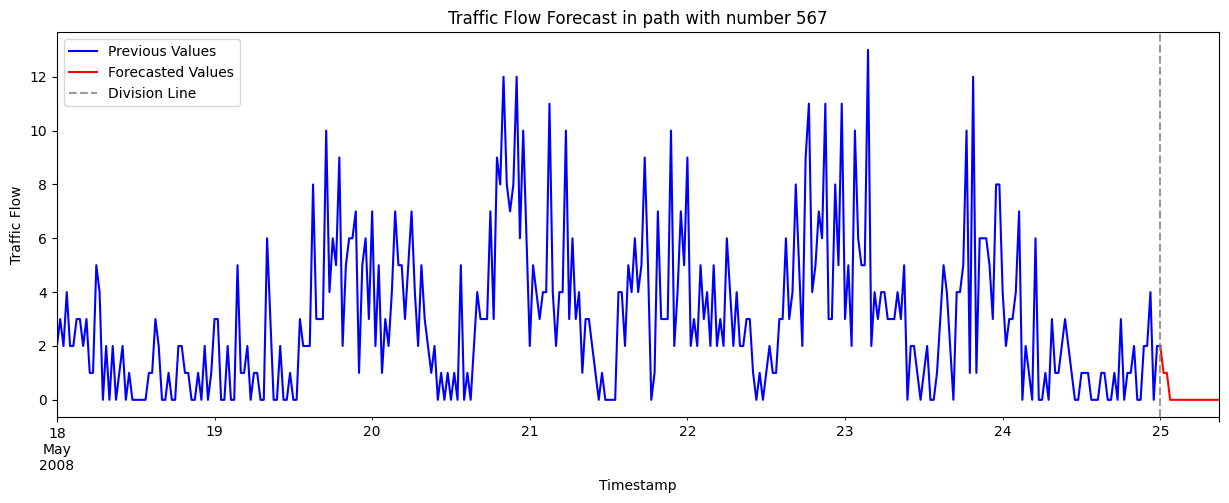

time: 368 ms (started: 2023-09-01 13:05:38 +00:00)


In [25]:
# plot actual and predicted values  of traffic flow in path with number 567
plot_actual_predicted(567)

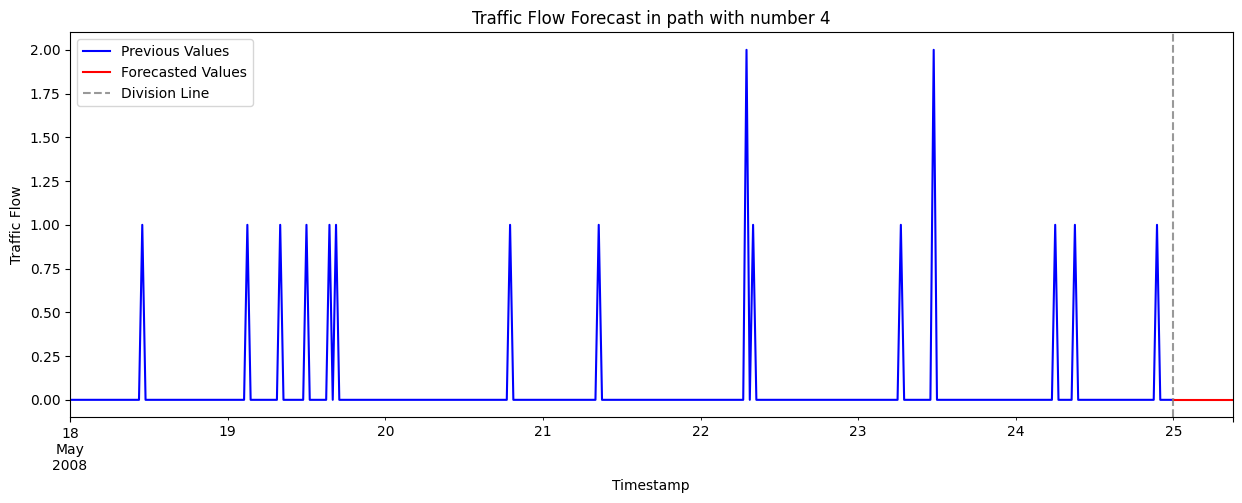

time: 353 ms (started: 2023-09-01 13:05:39 +00:00)


In [26]:
# plot actual and predicted values  of traffic flow in path with number 4
plot_actual_predicted(4)

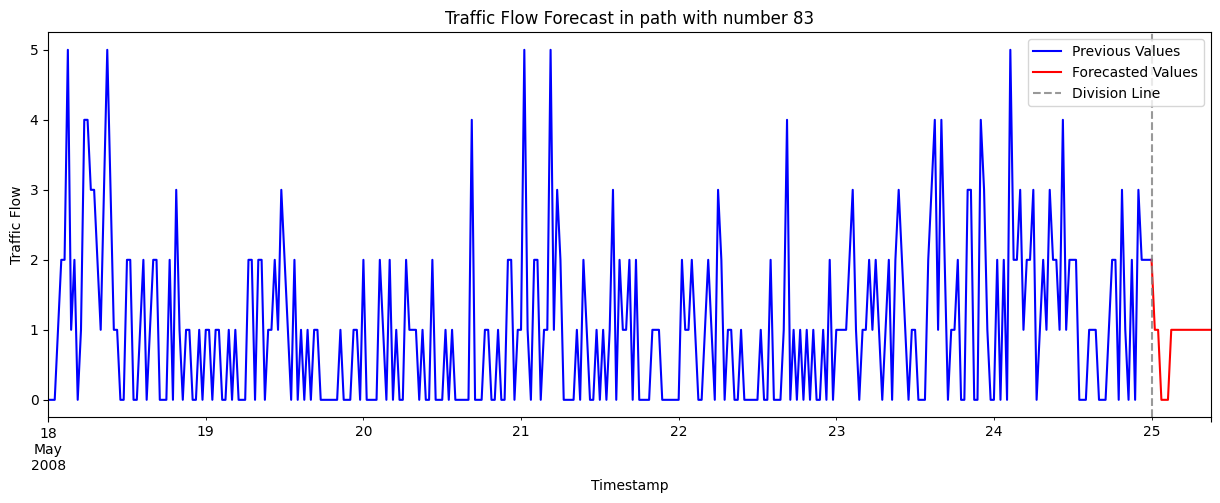

time: 328 ms (started: 2023-09-01 13:05:39 +00:00)


In [27]:
# plot actual and predicted values  of traffic flow in path with number 83
plot_actual_predicted(83)

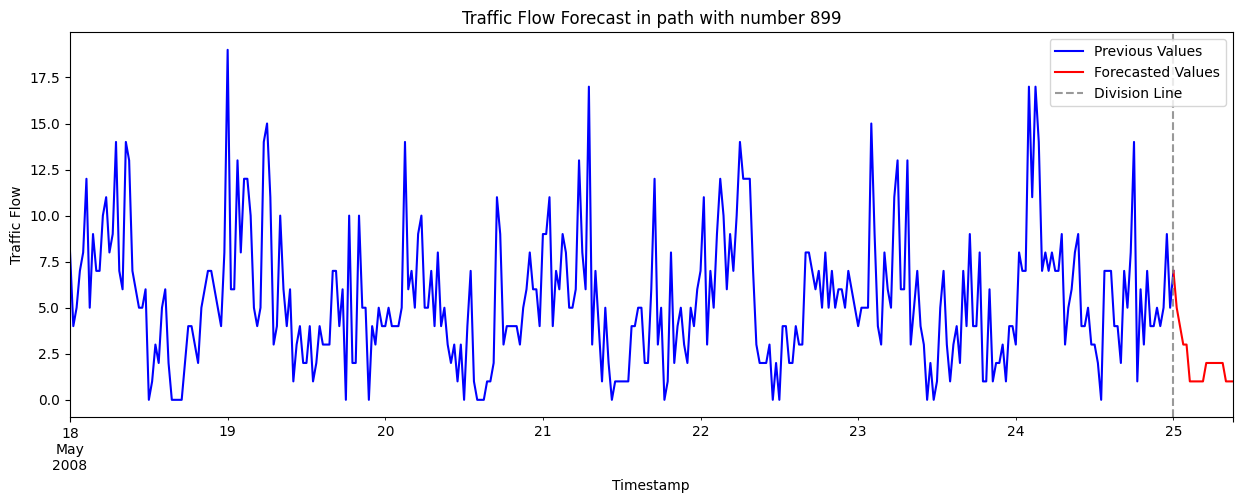

time: 344 ms (started: 2023-09-01 13:05:39 +00:00)


In [28]:
# plot actual and predicted values  of traffic flow in path with number 899
plot_actual_predicted(899)

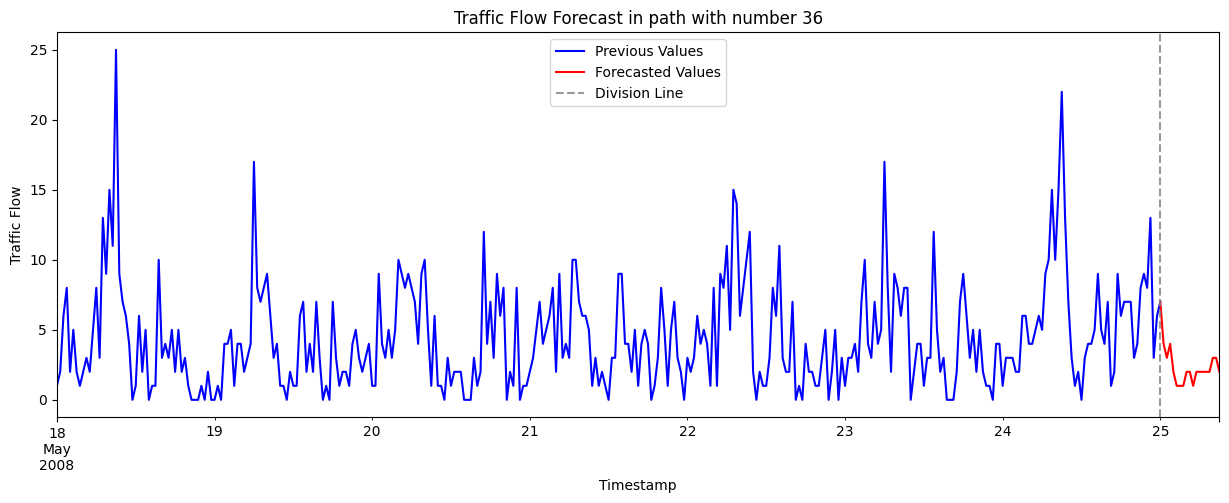

time: 314 ms (started: 2023-09-01 13:05:40 +00:00)


In [29]:
# plot actual and predicted values  of traffic flow in path with number 36
plot_actual_predicted(36)

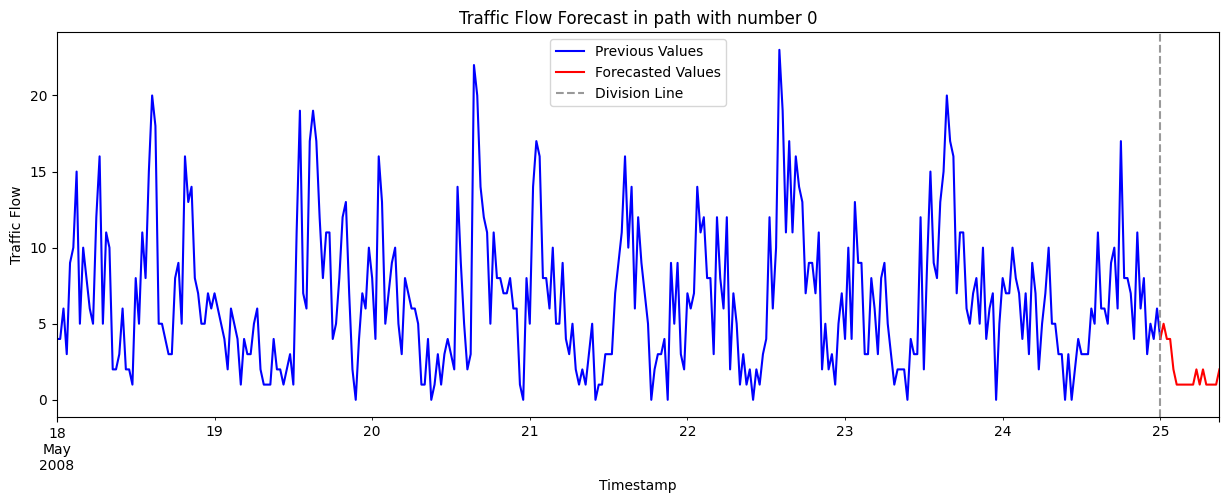

time: 328 ms (started: 2023-09-01 13:05:40 +00:00)


In [30]:
# plot actual and predicted values  of traffic flow in path with number 0
plot_actual_predicted(0)

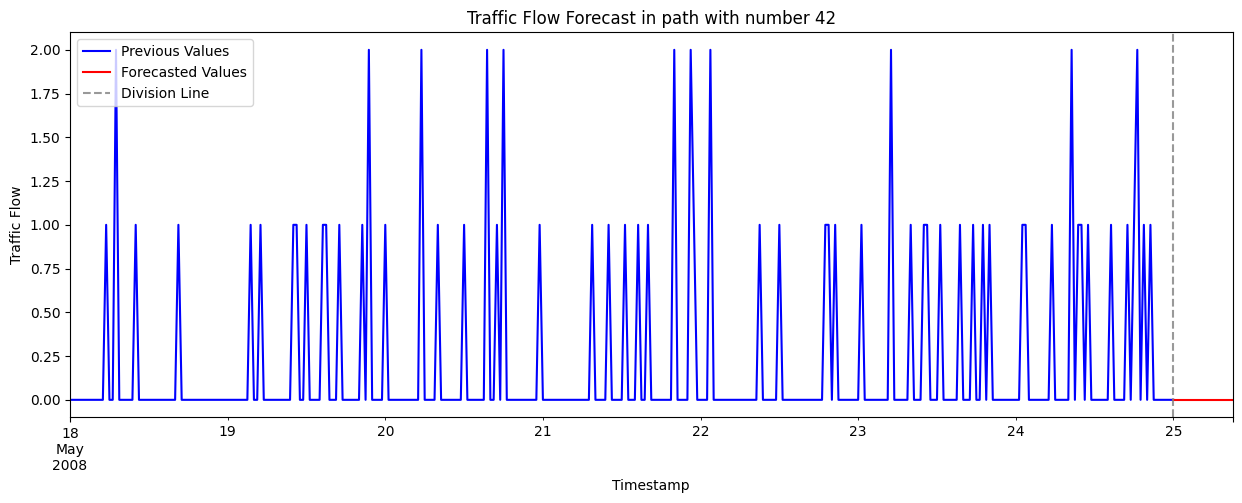

time: 350 ms (started: 2023-09-01 13:05:40 +00:00)


In [31]:
# plot actual and predicted values  of traffic flow in path with number 42
plot_actual_predicted(42)

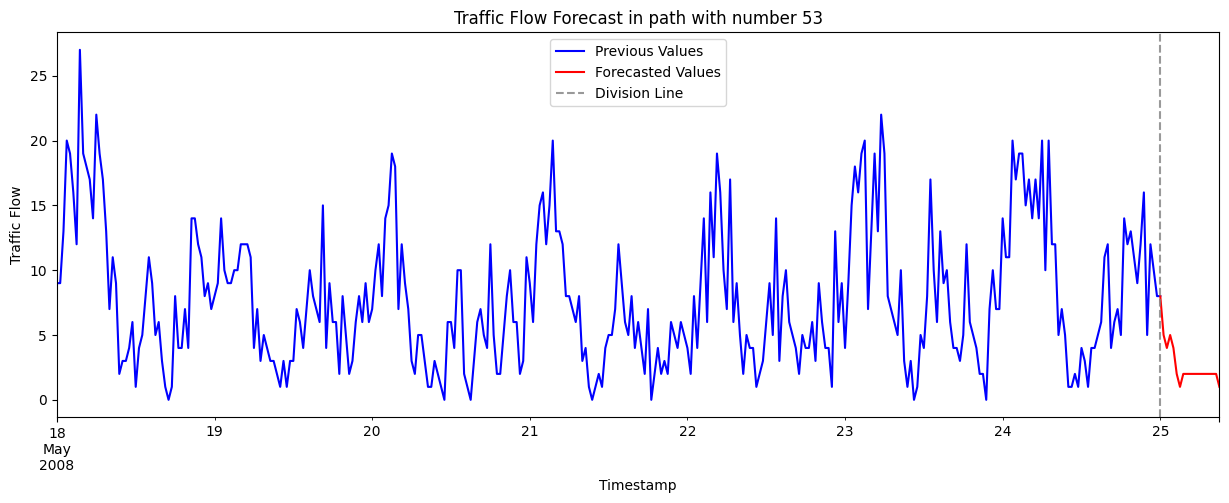

time: 320 ms (started: 2023-09-01 13:05:41 +00:00)


In [32]:
# plot actual and predicted values  of traffic flow in path with number 53
plot_actual_predicted(53)

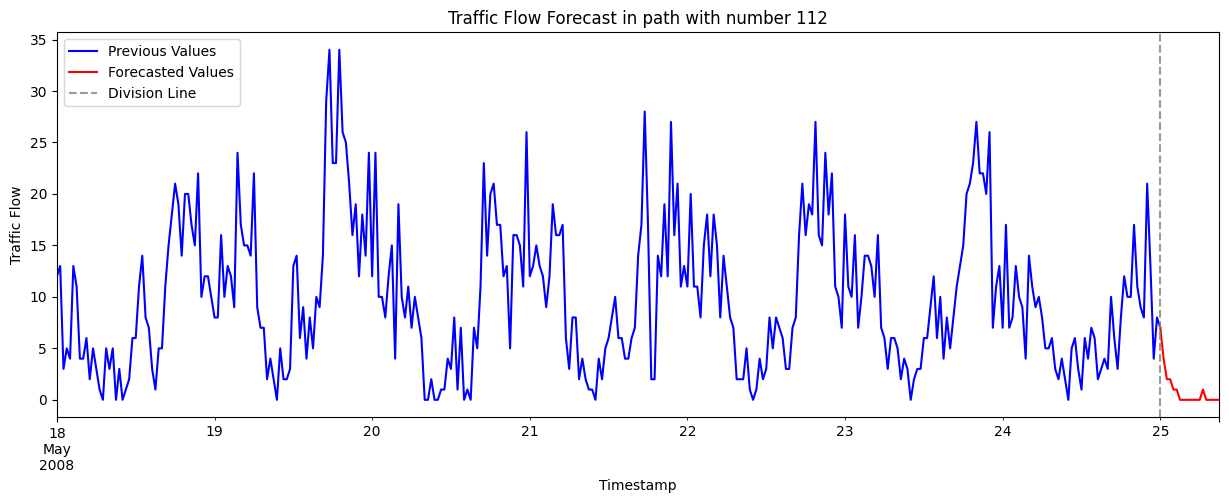

time: 408 ms (started: 2023-09-01 13:05:41 +00:00)


In [33]:
# plot actual and predicted values  of traffic flow in path with number 112
plot_actual_predicted(112)